In [167]:
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils.np_utils import to_categorical 
from keras.callbacks import ModelCheckpoint
from keras import Model
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import layer_utils, np_utils
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from classification_models import ResNet18
from classification_models.resnet import preprocess_input
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sn
import pandas as pd

In [57]:
image_width = 224
image_height = 224

# Change the batchsize according to your system RAM
batch_size = 64

nb_train_samples = 5000
nb_validation_samples = 278

#train_dir = "D:/retinal_data_set_visioncare/TrainValidationData/train"
train_dir = "D:/retinal_data_set_visioncare/TrainValidationData/augmented_train_data_224"
validation_dir = "D:/retinal_data_set_visioncare/TrainValidationData/validation"

resnet_base = ResNet18(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [58]:
x = resnet_base.get_layer(index=-1).output
feature_extraction_layer = GlobalAveragePooling2D()(x)
model = Model(inputs=resnet_base.input, outputs=feature_extraction_layer)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_73 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_73[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [59]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)

nb_train_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)

# get the class lebels for the training data, in the original order  
train_labels = train_generator.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 5000 images belonging to 5 classes.


In [60]:
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

nb_validation_samples = len(validation_generator.filenames)
validation_labels = validation_generator.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes) 

Found 278 images belonging to 5 classes.


In [61]:
np.array([0] * 1000 + [1] * 1000)

array([0, 0, 0, ..., 1, 1, 1])

In [62]:
validation_labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [60]:
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = model.predict_generator(train_generator, nb_train_samples // batch_size + 1)
# save the output as a Numpy array
np.save(open('D:/retinal_data_set_visioncare/models/resnet50/bottle_neck_features/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [61]:
bottleneck_features_validation = model.predict_generator(validation_generator, nb_validation_samples // batch_size + 1)
np.save(open('D:/retinal_data_set_visioncare/models/resnet50/bottle_neck_features/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [63]:
model_check_point_loc = 'D:/retinal_data_set_visioncare/models/resnet50/resnet_small_dr.h5'
model_checkpoint = ModelCheckpoint(model_check_point_loc, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

In [64]:
train_data = np.load(open('D:/retinal_data_set_visioncare/models/resnet50/bottle_neck_features/bottleneck_features_train.npy', 'rb'))
validation_data = np.load(open('D:/retinal_data_set_visioncare/models/resnet50/bottle_neck_features/bottleneck_features_validation.npy', 'rb'))

In [89]:
train_data.shape

(5000, 512)

In [90]:
train_data

array([[3.6700660e-01, 4.6685324e-03, 0.0000000e+00, ..., 2.0357642e+00,
        2.5800377e-01, 7.2768605e-01],
       [2.7020887e-01, 0.0000000e+00, 4.1414913e-02, ..., 2.0668449e+00,
        3.0984226e-01, 4.2722192e-01],
       [2.6386771e-01, 0.0000000e+00, 5.3467310e-04, ..., 1.0558809e+00,
        1.7614199e-01, 4.7931162e-01],
       ...,
       [5.4849721e-02, 5.1714156e-02, 1.5508796e-01, ..., 2.0143206e+00,
        5.0084794e-01, 7.5496852e-01],
       [2.5956971e-03, 2.2055119e-02, 1.9220503e-01, ..., 2.2250786e+00,
        4.9687845e-01, 5.8937383e-01],
       [2.5444182e-02, 1.3655716e-03, 1.2118161e-01, ..., 1.6942664e+00,
        7.5071913e-01, 6.0721153e-01]], dtype=float32)

In [91]:
# Feature Scaling - fature normalizing
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data)
X_validation = scaler.transform(validation_data)

In [92]:
X_train

array([[ 0.03975001, -0.6554805 , -0.4512492 , ...,  1.0930423 ,
        -0.6701826 ,  0.17333286],
       [-0.24518245, -0.68025625,  0.00444929, ...,  1.15193   ,
        -0.51952   , -0.60013694],
       [-0.26384822, -0.68025625, -0.44536608, ..., -0.7635142 ,
        -0.90810436, -0.46604502],
       ...,
       [-0.87911063, -0.40581068,  1.255222  , ...,  1.0524136 ,
         0.03561596,  0.24356477],
       [-1.0329249 , -0.56321037,  1.6636302 , ...,  1.4517306 ,
         0.0240791 , -0.18271738],
       [-0.9656684 , -0.6730092 ,  0.88214195, ...,  0.44601628,
         0.7618378 , -0.13679868]], dtype=float32)

In [114]:
train_data_labels = train_generator.classes  
   
# convert the training labels to categorical vectors  
#train_labels = to_categorical(train_labels, num_classes=num_classes)

In [115]:
train_X, validation_X, train_y, validation_y = train_test_split(X_train, train_data_labels, test_size = 0.2, random_state = 21)

In [117]:
validation_onehot_y = to_categorical(validation_y, num_classes=num_classes)

In [118]:
validation_onehot_y

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [102]:
new_model = Sequential()
#new_model.add(Flatten(input_shape=train_data.shape[1:]))
new_model.add(Dense(256, input_dim=512, activation='relu', kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001)))
new_model.add(Dropout(0.5))
# new_model.add(Dense(15, activation='relu', kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001)))
# new_model.add(Dropout(0.2))
new_model.add(Dense(5, kernel_initializer=initializers.he_normal(seed=None), activation='softmax'))

# new_model = Sequential()
# new_model.add(Dense(512, input_dim=512, activation='relu', kernel_initializer=initializers.he_normal(seed=None)))
# new_model.add(BatchNormalization())
# new_model.add(Dropout(0.5))
# # new_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer=initializers.he_normal(seed=None)))
# # new_model.add(BatchNormalization())
# # new_model.add(Dropout(0.5))
# new_model.add(Dense(5, kernel_initializer=initializers.he_normal(seed=None), activity_regularizer=regularizers.l2(0.001), activation='softmax'))

new_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

# history = new_model.fit(X_train, train_labels,
#           epochs=50,
#           batch_size=batch_size,
#           callbacks=[model_checkpoint],
#           validation_data=(X_validation, validation_labels))

history = new_model.fit(train_X, train_y,
          epochs=50,
          batch_size=batch_size,
          callbacks=[model_checkpoint],
          validation_data=(validation_X, validation_onehot_y))

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 5s 1ms/step - loss: 1.3986 - acc: 0.5973 - val_loss: 0.9656 - val_acc: 0.7730
Epoch 2/50
4000/4000 [==============================] - 0s 124us/step - loss: 0.9515 - acc: 0.7690 - val_loss: 0.8280 - val_acc: 0.8220
Epoch 3/50
4000/4000 [==============================] - 1s 126us/step - loss: 0.8005 - acc: 0.8257 - val_loss: 0.7559 - val_acc: 0.8410
Epoch 4/50
4000/4000 [==============================] - 1s 137us/step - loss: 0.7032 - acc: 0.8623 - val_loss: 0.7012 - val_acc: 0.8520
Epoch 5/50
4000/4000 [==============================] - 1s 151us/step - loss: 0.6478 - acc: 0.8775 - val_loss: 0.6714 - val_acc: 0.8620
Epoch 6/50
4000/4000 [==============================] - 1s 155us/step - loss: 0.5888 - acc: 0.9032 - val_loss: 0.6085 - val_acc: 0.8830
Epoch 7/50
4000/4000 [==============================] - 1s 143us/step - loss: 0.5504 - acc: 0.9075 - val_loss: 0.5885 - val_acc: 0.8890
Ep

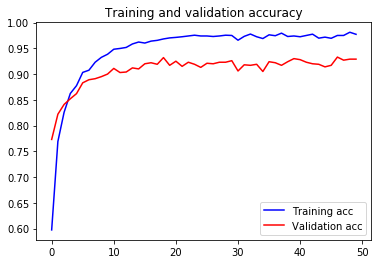

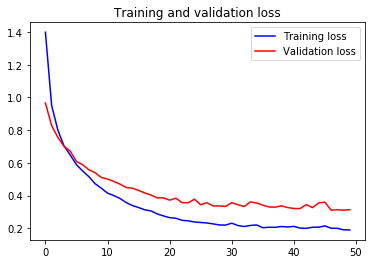

In [103]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [104]:
# Returns a compiled model identical to the previous one
loaded_model = load_model(model_check_point_loc)

In [119]:
#Confution Matrix and Classification Report
#Y_pred = loaded_model.predict_generator(validation_generator, validation_generator.samples // validation_generator.batch_size + 1)
Y_pred = loaded_model.predict(validation_X)
y_pred = np.argmax(Y_pred, axis=1)
#y_pred = np.asarray([1 if val >= 0.5 else 0 for val in Y_pred], dtype=numpy.int64)
print('Confusion Matrix')
print(confusion_matrix(validation_y, y_pred))
print('Classification Report')
target_names = ['non-dr', 'mild-npdr', 'moderate-npdr', 'severe-npdr', 'pdr']
print(classification_report(validation_y, y_pred, target_names=target_names))

Confusion Matrix
[[164  17   3   0   0]
 [ 16 178  10   0   1]
 [  5   5 188   2   1]
 [  0   1   2 203   3]
 [  0   0   0   1 200]]
Classification Report
               precision    recall  f1-score   support

       non-dr       0.89      0.89      0.89       184
    mild-npdr       0.89      0.87      0.88       205
moderate-npdr       0.93      0.94      0.93       201
  severe-npdr       0.99      0.97      0.98       209
          pdr       0.98      1.00      0.99       201

  avg / total       0.93      0.93      0.93      1000



In [120]:
y_pred

array([3, 0, 4, 2, 3, 4, 3, 1, 3, 1, 1, 0, 4, 4, 4, 2, 3, 4, 1, 4, 0, 4,
       4, 2, 0, 2, 0, 1, 0, 4, 2, 2, 1, 4, 0, 0, 0, 1, 0, 4, 4, 1, 3, 0,
       3, 0, 3, 0, 2, 1, 0, 1, 4, 0, 2, 2, 3, 1, 1, 2, 4, 4, 4, 1, 3, 2,
       3, 0, 3, 4, 1, 3, 3, 3, 1, 0, 1, 4, 1, 0, 0, 1, 1, 2, 0, 2, 2, 1,
       3, 2, 4, 4, 2, 4, 2, 3, 4, 1, 3, 3, 0, 4, 1, 3, 3, 2, 2, 0, 1, 3,
       3, 4, 4, 0, 2, 2, 4, 2, 2, 4, 3, 0, 1, 1, 0, 0, 4, 2, 2, 1, 4, 1,
       0, 4, 3, 0, 3, 2, 4, 2, 1, 3, 1, 3, 2, 1, 4, 2, 4, 2, 4, 3, 2, 4,
       4, 2, 3, 0, 1, 3, 3, 1, 3, 4, 2, 0, 0, 2, 4, 0, 4, 1, 3, 2, 1, 1,
       3, 4, 2, 3, 4, 2, 2, 3, 3, 3, 0, 1, 1, 2, 3, 4, 4, 1, 2, 2, 0, 0,
       3, 2, 2, 4, 2, 0, 3, 4, 2, 2, 0, 1, 4, 1, 3, 1, 1, 1, 1, 4, 2, 2,
       4, 3, 2, 0, 1, 4, 4, 1, 2, 2, 4, 3, 3, 4, 2, 4, 4, 2, 0, 3, 1, 4,
       1, 1, 4, 0, 1, 1, 0, 4, 2, 2, 3, 2, 2, 4, 3, 3, 0, 4, 4, 3, 4, 0,
       1, 2, 3, 2, 1, 0, 1, 4, 4, 3, 2, 1, 4, 1, 0, 4, 0, 0, 3, 2, 2, 4,
       3, 1, 3, 0, 4, 2, 4, 2, 3, 4, 0, 1, 2, 4, 4,

In [145]:
X = X_train
Y = train_data_labels

In [146]:
train_data_labels

array([0, 0, 0, ..., 4, 4, 4])

In [152]:
# define 5-fold cross validation test harness
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=30)
cvscores = []
trainScores = []
f1Score = []
num_k_folds = 10
fold_counter = 0
val_conmats = []
val_precisions = []
val_recalls = []
val_f_scores = []
input_dim = 512

cross_model = Sequential()
cross_model.add(Dense(256, input_dim=512, activation='relu', kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001)))
cross_model.add(Dropout(0.5))
# new_model.add(Dense(15, activation='relu', kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001)))
# new_model.add(Dropout(0.2))
cross_model.add(Dense(5, kernel_initializer=initializers.he_normal(seed=None), activation='softmax'))

cross_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [154]:
for train, test in kfold.split(X, Y):
    # Fit the model
    cross_model.fit(X[train], to_categorical(Y[train]), epochs=400, batch_size=batch_size, verbose=0)
    
    y_train_pred = cross_model.predict(X[train])
    y_train_pred = np.argmax(y_train_pred, axis=1)
    
    y_validation_pred = cross_model.predict(X[test])
    y_validation_pred = np.argmax(y_validation_pred, axis=1)
    #y_validation_pred = np.argmax(y_validation_pred, axis=1)
    
    [precision, recall, f_score, _] = precision_recall_fscore_support(Y[test], y_validation_pred)
    #print("Validation k-fold #%d - precision: %f, recallL: %f, f-score: %f" % (fold_counter, precision, recall, f_score))
    
    conmat = confusion_matrix(Y[test], y_validation_pred)
    
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f_scores.append(f_score)
    val_conmats.append(conmat)
    fold_counter = fold_counter + 1
    
    trainScores.append(accuracy_score(Y[train], y_train_pred))
    cvscores.append(accuracy_score(Y[test], y_validation_pred))
    
print("\nAveraging the 5-fold results:")
print("%s: %.2f%%" % ('AVG Train Acc ', np.mean(trainScores) * 100))
print("%s: %.2f%%" % ('AVG Validation Acc ', np.mean(cvscores) * 100))
print("Validation precision - mean: %f, stddev: %f" % (np.mean(val_precisions), np.std(val_precisions)))
print("Validation recall - mean: %f, stddev: %f" % (np.mean(val_recalls), np.std(val_recalls)))
print("Validation f-score - mean: %f, stddev: %f" % (np.mean(val_f_scores), np.std(val_f_scores)))
print("Confusion matrix:")
print (sum(val_conmats).astype(float) / fold_counter)


Averaging the 5-fold results:
AVG Train Acc : 99.94%
AVG Validation Acc : 94.91%
Validation precision - mean: 0.950606, stddev: 0.047006
Validation recall - mean: 0.949080, stddev: 0.049270
Validation f-score - mean: 0.949059, stddev: 0.040877
Confusion matrix:
[[8.782e+01 1.044e+01 1.700e+00 0.000e+00 4.000e-02]
 [4.440e+00 9.414e+01 1.300e+00 4.000e-02 8.000e-02]
 [2.000e+00 2.840e+00 9.388e+01 9.200e-01 3.600e-01]
 [0.000e+00 0.000e+00 6.000e-02 9.978e+01 1.600e-01]
 [0.000e+00 8.000e-02 2.800e-01 7.200e-01 9.892e+01]]


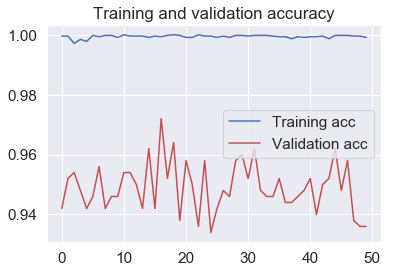

In [176]:
acc = trainScores
val_acc = cvscores
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.show()

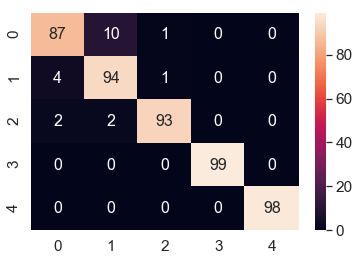

In [172]:
confusion_matrix_array = (sum(val_conmats).astype(float) / fold_counter)
new_confusion_matrix_array = []
for conf_sub_array in confusion_matrix_array:
    new_confusion_matrix_array.append([int(float(e)) for e in conf_sub_array])
        
df_cm = pd.DataFrame(new_confusion_matrix_array, range(5), range(5))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})# font size

In [171]:
new_confusion_matrix_array

[[87.82, 10.44, 1.7, 0.0, 0.04],
 [4.44, 94.14, 1.3, 0.04, 0.08],
 [2.0, 2.84, 93.88, 0.92, 0.36],
 [0.0, 0.0, 0.06, 99.78, 0.16],
 [0.0, 0.08, 0.28, 0.72, 98.92]]

In [158]:
# Save the model
cross_model.save('D:/retinal_data_set_visioncare/models/resnet50/resnet_max_acc_model.h5')

In [177]:
test_dir = "D:/retinal_data_set_visioncare/newTrainValidationTestData/new_test"

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

nb_test_samples = 142 
test_labels = test_generator.classes
bottleneck_features_test = model.predict_generator(test_generator, nb_test_samples // batch_size + 1)

X_test = scaler.transform(bottleneck_features_test)

Found 142 images belonging to 5 classes.


In [180]:
#Confution Matrix and Classification Report for testset
Y_pred_for_test = cross_model.predict(X_test)
Y_pred_for_test = np.argmax(Y_pred_for_test, axis=1)
print('Confusion Matrix for testset')
confusion_matrix_for_testset = confusion_matrix(test_labels, Y_pred_for_test)
print(confusion_matrix(test_labels, Y_pred_for_test))
print('Classification Report')
target_names = ['non-dr', 'mild-npdr', 'moderate-npdr', 'severe-npdr', 'pdr']
print(classification_report(test_labels, Y_pred_for_test, target_names=target_names))

Confusion Matrix for testset
[[64 12  0  0  0]
 [ 4 15  0  0  0]
 [ 0  5 18  0  0]
 [ 0  0  0  9  0]
 [ 0  0  0  1 14]]
Classification Report
               precision    recall  f1-score   support

       non-dr       0.94      0.84      0.89        76
    mild-npdr       0.47      0.79      0.59        19
moderate-npdr       1.00      0.78      0.88        23
  severe-npdr       0.90      1.00      0.95         9
          pdr       1.00      0.93      0.97        15

  avg / total       0.89      0.85      0.86       142



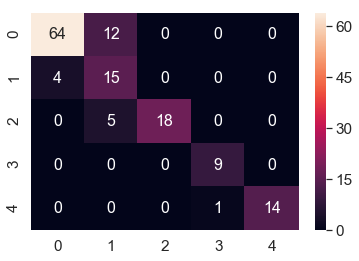

In [181]:
df_cm_test = pd.DataFrame(confusion_matrix_for_testset, range(5), range(5))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm_test, annot=True, annot_kws={"size": 16})# font size